# Situering
- De eigenaar van een huishoudelijke zonnepaneelinstallatie zou graag continu een voorspelling hebben van de opbrengst van zijn panelen gedurende de komende uren om het eigen verbruik te optimaliseren: bij een verwachte hoge opbrengst kan hij dan bijv. beslissen om de wasmachine aan te zetten. 
- Hij beschikt over de meterstand per uur sedert ongeveer één jaar (solar.csv). 
- Daarnaast zijn ook de gegevens van de waarnemingen van het weer (weather.csv) en 
- de uren van zonsopgang en –ondergang in dezelfde periode periode (sunrise-sunset.xlsx). 

# Vraag
- Stel een regressiemodel op om de opbrengst per uur te voorspellen. 
- Kies een optimaal regressiemodel door verschillende modellen uit te proberen en te vergelijken volgens de "best practices". 
- Kies als maatstaf de gemiddelde afwijking van de absolute waarde op uurbasis.




In [1]:
import sys
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime

## Preparation and cleanup of solar data

In [2]:
def prepare_solar():
    solar = pd.read_csv('datasets/solar.csv')  
    print(solar.head(10))
    print('-------------')
    print(solar.tail(10))
    solar['datetime'] = pd.to_datetime(solar['timestamp'].str[0:19],format='%Y-%m-%d %H:%M:%S')      
    solar['datetime_tz'] = solar['datetime'].dt.tz_localize('Europe/Berlin',ambiguous='NaT')
    solar['datetime_utc'] = solar['datetime_tz'].dt.tz_convert('UTC')
    solar['date'] = solar['datetime_utc'].dt.date
    solar['hour'] = solar['datetime_utc'].dt.hour
    solar = solar[['date','hour','kwh']]
    solar.dropna(inplace=True)
    solar.drop_duplicates(inplace=True)
    # todo timediff en alles > 1u er uit. 
    return solar

solar = prepare_solar()
solar.info()
solar.head()

                       timestamp   kwh
0  2023-03-11 16:00:10.160454+01  0.54
1  2023-03-11 17:00:10.217795+01  1.02
2  2023-03-11 18:00:10.284064+01  1.17
3  2023-03-11 19:00:10.224836+01  1.18
4  2023-03-11 20:00:10.201847+01  1.18
5  2023-03-11 21:00:10.338166+01  1.18
6  2023-03-11 22:00:10.189411+01  1.18
7   2023-03-11 23:00:10.14459+01  1.18
8  2023-03-12 00:00:10.058642+01  1.18
9  2023-03-12 01:00:10.136006+01  1.18
-------------
                          timestamp        kwh
9695  2024-04-19 01:00:10.322579+02  2417.3321
9696  2024-04-19 02:00:10.339044+02  2417.3321
9697  2024-04-19 03:00:10.343655+02  2417.3321
9698  2024-04-19 04:00:10.507106+02  2417.3321
9699  2024-04-19 05:00:10.326829+02  2417.3321
9700  2024-04-19 06:00:10.326636+02  2417.3321
9701  2024-04-19 07:00:10.424826+02  2417.3321
9702  2024-04-19 08:00:10.360449+02  2417.3336
9703  2024-04-19 09:00:10.437154+02  2417.3701
9704  2024-04-19 10:00:10.748713+02  2417.4788
<class 'pandas.core.frame.DataFrame'>
In

,date,hour,kwh
0,2023-03-11,15.0,0.54
1,2023-03-11,16.0,1.02
2,2023-03-11,17.0,1.17
3,2023-03-11,18.0,1.18
4,2023-03-11,19.0,1.18


In [3]:
solar.tail()

,date,hour,kwh
9700,2024-04-19,4.0,2417.3321
9701,2024-04-19,5.0,2417.3321
9702,2024-04-19,6.0,2417.3336
9703,2024-04-19,7.0,2417.3701
9704,2024-04-19,8.0,2417.4788


## Preparation and cleanup of weather data

In [4]:
def prepare_weather():
    weather = pd.read_csv("datasets/weather.csv")
    print(weather.head(10))
    weather = weather[['timestamp','temp','pressure','cloudiness','humidity_relative']]
    weather = weather.groupby(by=['timestamp']).mean().reset_index()
    weather['datetime'] = pd.to_datetime(weather['timestamp'],format='%Y-%m-%dT%H:%M:%S')
    weather['date'] = weather['datetime'].dt.date
    weather['hour'] = weather['datetime'].dt.hour   
    weather = weather[['date','hour','temp','pressure','cloudiness','humidity_relative']]
    weather.drop_duplicates(inplace=True)
    return weather

weather = prepare_weather()
weather.info()
weather.head(30)


                                      FID                    the_geom  code  \
0  synop_data.6418.2023-03-01 09:00:00+00  POINT (51.347375 3.201846)  6418   
1  synop_data.6414.2023-03-01 09:00:00+00   POINT (50.90398 3.121692)  6414   
2  synop_data.6407.2023-03-01 09:00:00+00  POINT (51.200341 2.887306)  6407   
3  synop_data.6434.2023-03-01 09:00:00+00  POINT (50.980293 3.816003)  6434   
4  synop_data.6434.2023-03-01 10:00:00+00  POINT (50.980293 3.816003)  6434   
5  synop_data.6418.2023-03-01 10:00:00+00  POINT (51.347375 3.201846)  6418   
6  synop_data.6414.2023-03-01 10:00:00+00   POINT (50.90398 3.121692)  6414   
7  synop_data.6407.2023-03-01 10:00:00+00  POINT (51.200341 2.887306)  6407   
8  synop_data.6414.2023-03-01 11:00:00+00   POINT (50.90398 3.121692)  6414   
9  synop_data.6418.2023-03-01 11:00:00+00  POINT (51.347375 3.201846)  6418   

             timestamp  precip_quantity  precip_range  temp  temp_min  \
0  2023-03-01T09:00:00              NaN           NaN   4

,date,hour,temp,pressure,cloudiness,humidity_relative
0,2023-03-01,9,2.975,1029.500,0.5,66.300000
1,2023-03-01,10,4.000,1029.150,0.5,60.900000
2,2023-03-01,11,4.800,1028.575,0.5,55.000000
3,2023-03-01,12,5.375,1028.100,0.5,53.166667
4,2023-03-01,13,5.900,1027.125,0.5,51.833333
5,2023-03-01,14,5.950,1026.350,0.5,53.400000
6,2023-03-01,15,5.975,1025.625,0.5,55.366667
7,2023-03-01,16,5.700,1025.075,0.5,57.466667
8,2023-03-01,17,5.300,1024.725,0.5,58.866667
9,2023-03-01,18,4.700,1024.825,0.5,58.800000


## Preparation and cleanup of sunrise/sunset data

In [5]:
!pip install openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
def prepare_sunrise_sunset():
    sunrise_sunset = pd.read_excel("datasets/sunrise-sunset.xlsx") 
    print(sunrise_sunset.head(10))
    sunrise_sunset.rename(columns={'datum':'date'}, inplace=True)
    sunrise_sunset['sunrise'] = [pd.Timestamp.combine(d,t) for d,t in zip(sunrise_sunset['date'],sunrise_sunset['Opkomst'])]
    sunrise_sunset['noon'] = [pd.Timestamp.combine(d,t) for d,t in zip(sunrise_sunset['date'],sunrise_sunset['Op ware middag'])]
    sunrise_sunset['sunset'] = [pd.Timestamp.combine(d,t) for d,t in zip(sunrise_sunset['date'],sunrise_sunset['Ondergang'])]
    sunrise_sunset['sunrise'] = sunrise_sunset['sunrise'].dt.tz_localize('Europe/Berlin',ambiguous='NaT')
    sunrise_sunset['sunrise'] = sunrise_sunset['sunrise'].dt.tz_convert('UTC')
    sunrise_sunset['sunset'] = sunrise_sunset['sunset'].dt.tz_localize('Europe/Berlin',ambiguous='NaT')
    sunrise_sunset['sunset'] = sunrise_sunset['sunset'].dt.tz_convert('UTC')
    sunrise_sunset['date'] = sunrise_sunset['date'].dt.date
    sunrise_sunset = sunrise_sunset[['date','sunrise','sunset']]
    return sunrise_sunset

sunrise_sunset = prepare_sunrise_sunset()
sunrise_sunset.info()
sunrise_sunset.head()

       datum   Opkomst Op ware middag Ondergang
0 2023-01-01  08:45:00       12:46:00  16:47:00
1 2023-01-02  08:45:00       12:46:00  16:48:00
2 2023-01-03  08:45:00       12:47:00  16:49:00
3 2023-01-04  08:44:00       12:47:00  16:51:00
4 2023-01-05  08:44:00       12:48:00  16:52:00
5 2023-01-06  08:44:00       12:48:00  16:53:00
6 2023-01-07  08:43:00       12:49:00  16:54:00
7 2023-01-08  08:43:00       12:49:00  16:56:00
8 2023-01-09  08:43:00       12:50:00  16:57:00
9 2023-01-10  08:42:00       12:50:00  16:58:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   date     731 non-null    object             
 1   sunrise  731 non-null    datetime64[ns, UTC]
 2   sunset   731 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), object(1)
memory usage: 17.3+ KB


,date,sunrise,sunset
0,2023-01-01,2023-01-01 07:45:00+00:00,2023-01-01 15:47:00+00:00
1,2023-01-02,2023-01-02 07:45:00+00:00,2023-01-02 15:48:00+00:00
2,2023-01-03,2023-01-03 07:45:00+00:00,2023-01-03 15:49:00+00:00
3,2023-01-04,2023-01-04 07:44:00+00:00,2023-01-04 15:51:00+00:00
4,2023-01-05,2023-01-05 07:44:00+00:00,2023-01-05 15:52:00+00:00


Combine solar and weather data in a single dataframe. 

In [7]:
solar_weather = pd.merge(solar, weather, on=['date','hour'], how='inner')
solar_weather.info()
solar_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9340 entries, 0 to 9339
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               9340 non-null   object 
 1   hour               9340 non-null   float64
 2   kwh                9340 non-null   float64
 3   temp               9340 non-null   float64
 4   pressure           9340 non-null   float64
 5   cloudiness         9340 non-null   float64
 6   humidity_relative  9340 non-null   float64
dtypes: float64(6), object(1)
memory usage: 510.9+ KB


,date,hour,kwh,temp,pressure,cloudiness,humidity_relative
0,2023-03-11,15.0,0.54,6.85,1012.025,6.0,54.833333
1,2023-03-11,16.0,1.02,6.30,1011.625,7.0,57.800000
2,2023-03-11,17.0,1.17,5.95,1011.500,7.0,60.366667
3,2023-03-11,18.0,1.18,5.25,1011.850,7.0,64.500000
4,2023-03-11,19.0,1.18,4.85,1011.650,7.0,68.633333


Now also combine this dataset with sunrise_sunset. 

In [8]:
all = pd.merge(solar_weather,sunrise_sunset,how='left', on='date')
all.info()
all.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9340 entries, 0 to 9339
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   date               9340 non-null   object             
 1   hour               9340 non-null   float64            
 2   kwh                9340 non-null   float64            
 3   temp               9340 non-null   float64            
 4   pressure           9340 non-null   float64            
 5   cloudiness         9340 non-null   float64            
 6   humidity_relative  9340 non-null   float64            
 7   sunrise            9340 non-null   datetime64[ns, UTC]
 8   sunset             9340 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(6), object(1)
memory usage: 656.8+ KB


,date,hour,kwh,temp,pressure,cloudiness,humidity_relative,sunrise,sunset
0,2023-03-11,15.0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11 06:06:00+00:00,2023-03-11 17:40:00+00:00
1,2023-03-11,16.0,1.02,6.30,1011.625,7.0,57.800000,2023-03-11 06:06:00+00:00,2023-03-11 17:40:00+00:00
2,2023-03-11,17.0,1.17,5.95,1011.500,7.0,60.366667,2023-03-11 06:06:00+00:00,2023-03-11 17:40:00+00:00
3,2023-03-11,18.0,1.18,5.25,1011.850,7.0,64.500000,2023-03-11 06:06:00+00:00,2023-03-11 17:40:00+00:00
4,2023-03-11,19.0,1.18,4.85,1011.650,7.0,68.633333,2023-03-11 06:06:00+00:00,2023-03-11 17:40:00+00:00


## Feature Engineering
Only keep following features: 
- dayinyear: number of the day in de year (1/1 = 1, 31/12 = 365)
- sunrise_delta: hours after sunrise
- sunset_delta: hours before sunset
- temp
- pressure
- cloudiness
- humidity
- production (kW): yield of the current hour

In [9]:
def prepare_all(all):
    all['date'] = pd.to_datetime(all['date'])
    all['hour'] = all['hour'].astype('int')
    all['dayinyear'] = all['date'].dt.strftime('%j').astype(int)
    all['production'] = all['kwh'] - all['kwh'].shift(1)
    all['sunrise_delta'] = all['hour'] - all['sunrise'].dt.hour # uren na zonsopgang
    all['sunset_delta'] = all['sunset'].dt.hour - all['hour'] # uren voor zonsondergang
    return all[['dayinyear','sunrise_delta','sunset_delta','temp','pressure','cloudiness','humidity_relative','production']]

all_final = prepare_all(all)
all_final.info()
print(all_final.head(30))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9340 entries, 0 to 9339
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dayinyear          9340 non-null   int64  
 1   sunrise_delta      9340 non-null   int64  
 2   sunset_delta       9340 non-null   int64  
 3   temp               9340 non-null   float64
 4   pressure           9340 non-null   float64
 5   cloudiness         9340 non-null   float64
 6   humidity_relative  9340 non-null   float64
 7   production         9339 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 583.9 KB
    dayinyear  sunrise_delta  sunset_delta    temp  pressure  cloudiness  \
0          70              9             2   6.850  1012.025         6.0   
1          70             10             1   6.300  1011.625         7.0   
2          70             11             0   5.950  1011.500         7.0   
3          70             12            -1   5.250  1011.8

Create a histogram for all numerical features

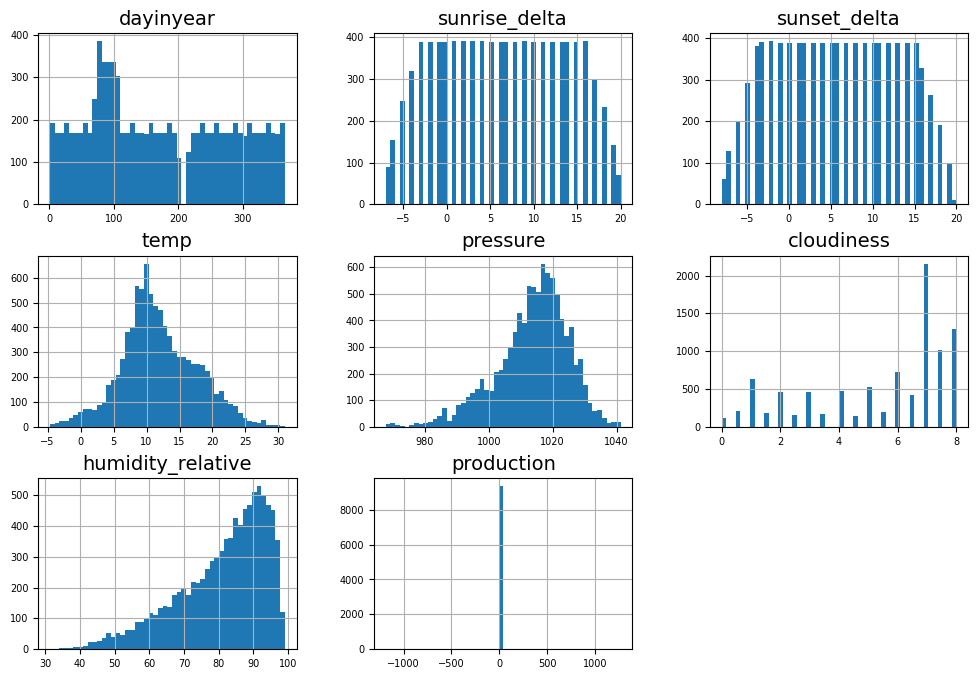

In [10]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

all_final.hist(bins=50, figsize=(12, 8))
plt.show()

In [12]:
all_final.tail(30)

,dayinyear,sunrise_delta,sunset_delta,temp,pressure,cloudiness,humidity_relative,production
9310,109,-1,15,4.125,1017.675,3.5,93.300000,0.0000
9311,109,0,14,3.975,1018.250,3.5,92.266667,0.0000
9312,109,1,13,4.175,1019.150,2.0,91.800000,0.0000
9313,109,2,12,5.300,1020.050,1.0,89.133333,0.0138
9314,109,3,11,7.525,1020.950,4.0,84.133333,0.0744
9315,109,4,10,8.425,1021.425,6.0,75.500000,0.2719
9316,109,5,9,9.400,1022.175,4.0,68.700000,0.6478
9317,109,6,8,9.425,1022.575,5.5,66.900000,1.0731
9318,109,7,7,9.950,1022.850,4.0,67.566667,0.8519
9319,109,8,6,10.800,1022.750,5.0,66.066667,1.2868


Which column requires further attention? Find the odd data en fix it. 

In [13]:
all_final['production'].describe()

count    9339.000000
mean        0.258801
std        17.985281
min     -1185.158200
25%         0.000000
50%         0.000000
75%         0.253200
max      1269.965600
Name: production, dtype: float64

In [14]:
all_final.head()

,dayinyear,sunrise_delta,sunset_delta,temp,pressure,cloudiness,humidity_relative,production
0,70,9,2,6.85,1012.025,6.0,54.833333,NaN
1,70,10,1,6.30,1011.625,7.0,57.800000,0.48
2,70,11,0,5.95,1011.500,7.0,60.366667,0.15
3,70,12,-1,5.25,1011.850,7.0,64.500000,0.01
4,70,13,-2,4.85,1011.650,7.0,68.633333,0.00


In [15]:
all_final.dropna(inplace=True)
all_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9339 entries, 1 to 9339
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dayinyear          9339 non-null   int64  
 1   sunrise_delta      9339 non-null   int64  
 2   sunset_delta       9339 non-null   int64  
 3   temp               9339 non-null   float64
 4   pressure           9339 non-null   float64
 5   cloudiness         9339 non-null   float64
 6   humidity_relative  9339 non-null   float64
 7   production         9339 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 656.6 KB


C:\Users\jcor864\AppData\Local\Temp\ipykernel_19056\2344629943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_final.dropna(inplace=True)


In [17]:
all_final = all_final[(all_final['production'] >= 0) & ((all_final['production'] < 10))]

In [20]:
all_final.describe()

,dayinyear,sunrise_delta,sunset_delta,temp,pressure,cloudiness,humidity_relative,production
count,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000,9336.000000
mean,173.132819,6.416238,5.778813,11.900000,1013.703682,5.427217,81.008098,0.245923
std,105.503348,7.062461,7.079473,5.700406,11.307859,2.402268,12.788354,0.451651
min,1.000000,-7.000000,-8.000000,-4.650000,967.800000,0.000000,31.366667,0.000000
25%,84.000000,0.000000,0.000000,8.325000,1007.625000,3.500000,73.266667,0.000000
50%,158.000000,6.000000,6.000000,11.225000,1015.325000,6.500000,84.166667,0.000000
75%,268.000000,12.000000,12.000000,15.700000,1021.425000,7.000000,91.166667,0.252825
max,365.000000,20.000000,20.000000,30.975000,1041.275000,8.000000,99.033333,2.098000


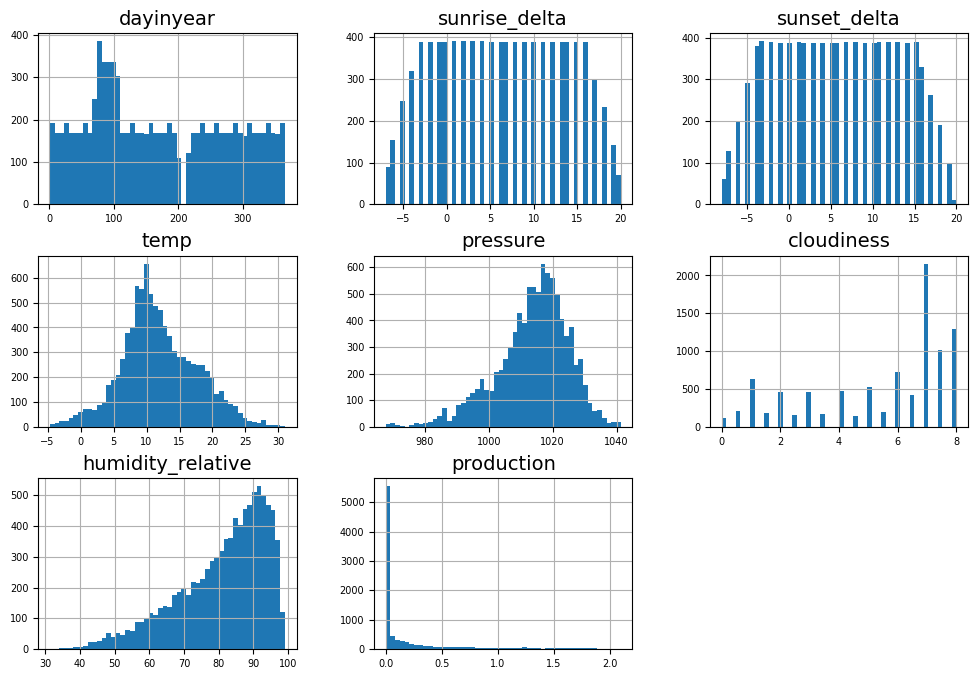

In [21]:
all_final.hist(bins=50, figsize=(12, 8))
plt.show()

Store the current dataframe to a csv file so we can use it later. 

In [22]:
all_final.to_csv('datasets/all_final.csv',index=False)

Read the data from the csv file

In [23]:
all_final = pd.read_csv('datasets/all_final.csv')

Split the dataset in a training and a testset

In [24]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(all_final, test_size=0.2, random_state=42)


In [25]:
len(train_set), len(test_set)

(7468, 1868)

Create a Random Forest model to predict the hourly production. 
- Create a pipeline with a StandardScaler and and a random forest regressor
- Find the optimal parameter combination amongst
  - bootstrap: False, True
  - n_estimators: 50 - 200 with steps of 50
  - max_depth: 10 - 50 with steps of 10 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

attribs = train_set.drop('production', axis=1)
labels = train_set['production'].copy()

forest_reg = RandomForestRegressor(random_state=42)
param_grid = [
    {'randomforestregressor__n_estimators': np.arange(50,201,50), 'randomforestregressor__max_depth': np.arange(10,51,10)},
    {'randomforestregressor__bootstrap': [False], 'randomforestregressor__n_estimators': np.arange(50,201,50), 
              'randomforestregressor__max_depth': np.arange(10,51,10)} 
  ]

pipeline = make_pipeline(StandardScaler(), forest_reg)
grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='neg_mean_absolute_error', return_train_score=True,
                           verbose=4, n_jobs=-1)

grid_search.fit(attribs, labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

{'randomforestregressor__max_depth': np.int64(30), 'randomforestregressor__n_estimators': np.int64(100)}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=np.int64(30),
                                       n_estimators=np.int64(100),
                                       random_state=42))])
-0.06405352283712315


Determine the mean absolute error on the test set. Is this a useful model? 

In [29]:
from sklearn.metrics import mean_absolute_error

final_model = grid_search.best_estimator_
test_attribs = test_set.drop('production', axis=1)
test_labels = test_set['production'].copy()
test_predictions = final_model.predict(test_attribs)
final_mae = mean_absolute_error(test_labels, test_predictions)
final_mae

0.061031969486083214

Explain the concept of noise in this context

beschaduwing, vervuiling

Store the model to a file. 

In [31]:
import joblib
joblib.dump(final_model, 'solar_production.pkl')

['solar_production.pkl']